Importing the necessary libraries and downloading the data

In [ ]:
!pip install transformers -q
!pip install gdown==4.6.0

import re
import nltk
import torch
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.special import softmax
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm.notebook import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
plt.style.use('ggplot')

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
!gdown 1WSpwmT4rTi9W18GgcB83fyueZfae3DWw

Downloading...
From: https://drive.google.com/uc?id=1WSpwmT4rTi9W18GgcB83fyueZfae3DWw
To: /content/all_combined_exactmatches.csv
100% 9.55M/9.55M [00:00<00:00, 71.6MB/s]


# Preprocessing

In [ ]:
 # Read the CSV file into a DataFrame
df = pd.read_csv('all_combined_exactmatches.csv', encoding = 'utf-8')

def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)        # Remove or handle HTML tags
    text = re.sub(r'http\S+', '', text)      # Remove links
    text = re.sub(r'-&gt;', '', text)        # Remove '-&gt;'
    text = re.sub(r'&amp;', '', text)        # Remove '&amp;'
    text = re.sub(r'\**', '', text)          # Remove '*'
    text = re.sub(r'#x200B;', '', text)      # Remove '&amp;#x200B;'
    text = re.sub(r'&lt;', '', text)         # Remove '&lt;'
    text = re.sub(r'ÃÂÃÂ', '', text)         # Remove '*ÃÂÃÂ'
    text = re.sub(r'\d', '', text)           # Remove digits
    text = re.sub(r'#\w+;', '', text)        # Remove patterns like '#=A', '#xB;
    text = re.sub(r'@', '', text)
    text = re.sub(r'#*', '', text)

    # Remove non-UTF-8 symbols
    text = text.encode('utf-8', 'ignore').decode('utf-8')
    return text

# Apply the preprocess_text function to the 'text' column
df['text'] = df['text'].apply(preprocess_text)
df['title'] = df['title'].apply(preprocess_text)

# Add an 'id' column
df['id'] = df.reset_index(drop=True).index + 1

# Remove newline characters
df['text'] = df['text'].str.replace('\n', '', regex=False)

# Print the DataFrame
print(df.head())

     date_utc   timestamp                                              title  \
0  01.02.2014  1391261706  vacuous imagery, cheap clichÃÂÃÂ©s, and fau...   
1  15.06.2023  1686797377  Is it possible to reverse illness with manifes...   
2  07.06.2023  1686109290  Does our hair really have a spiritual connecti...   
3  14.11.2023  1699960847                      Psychic or spiritual interest   
4  05.05.2023  1683315350     How are Spirituality and Philosophy different?   

                                                text     subreddit  comments  \
0  Most of us like to think of ourselves as sensi...  spirituality         0   
1  So I'm desperate. Doctors can help me they pre...  spirituality        57   
2  I always heard throughout the net that our hai...  spirituality        36   
3  Hello everyone. I am interested in psychic or ...  spirituality         5   
4  I am usually fancinated by ideas invoked by pr...  spirituality        17   

                                      

# Data Exploration

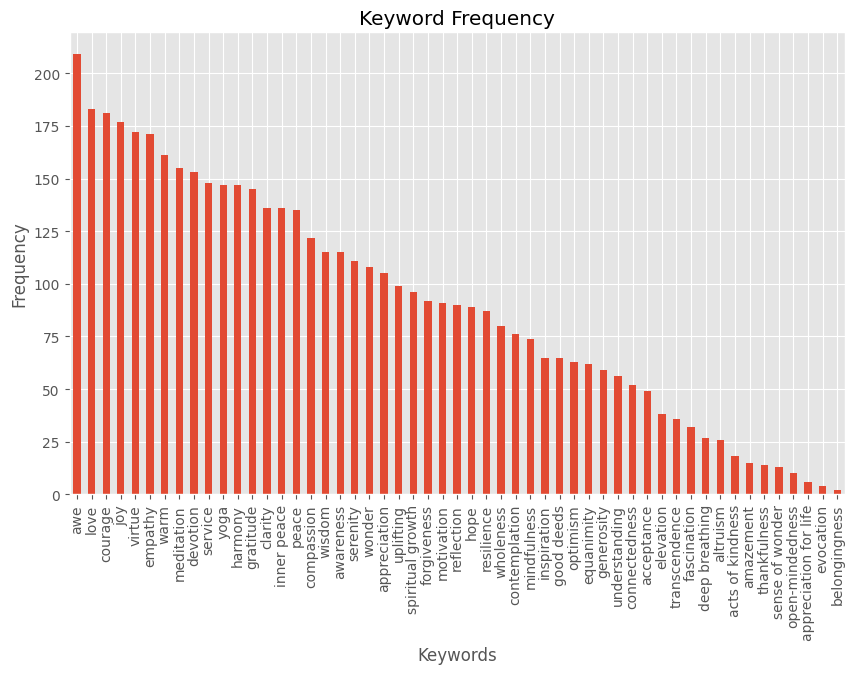

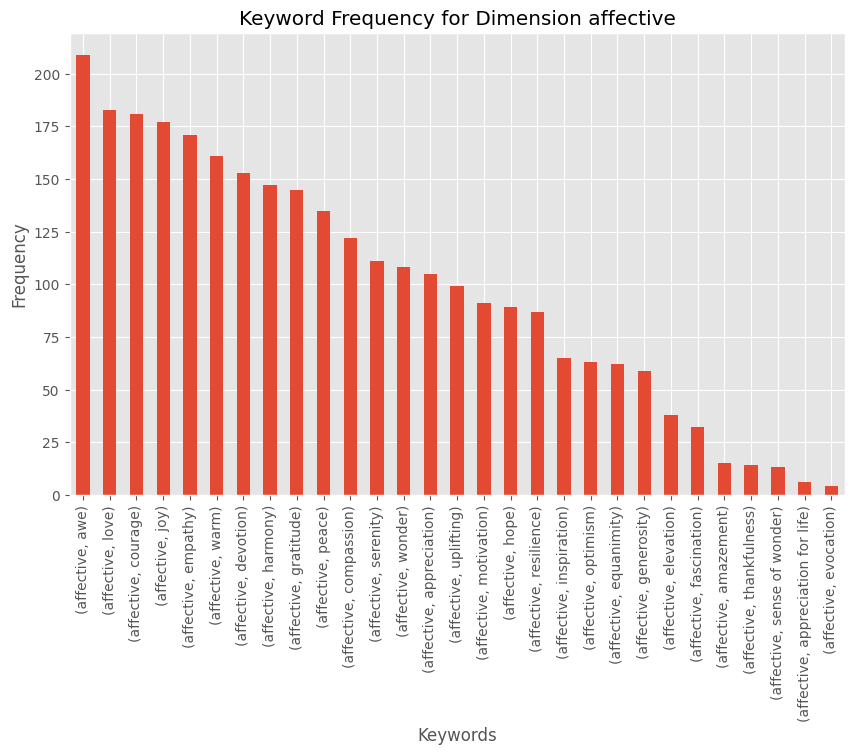

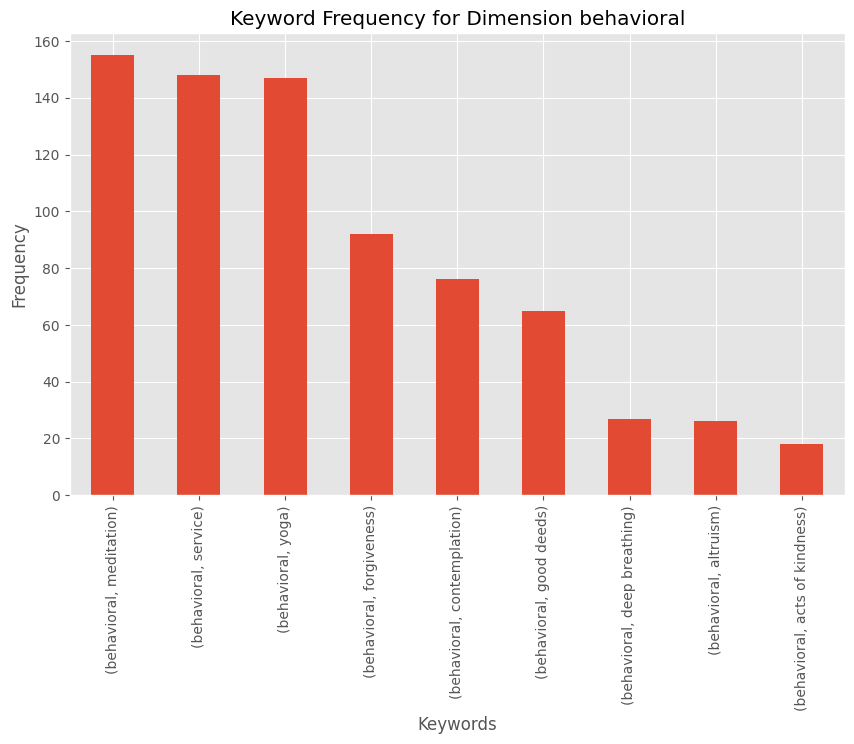

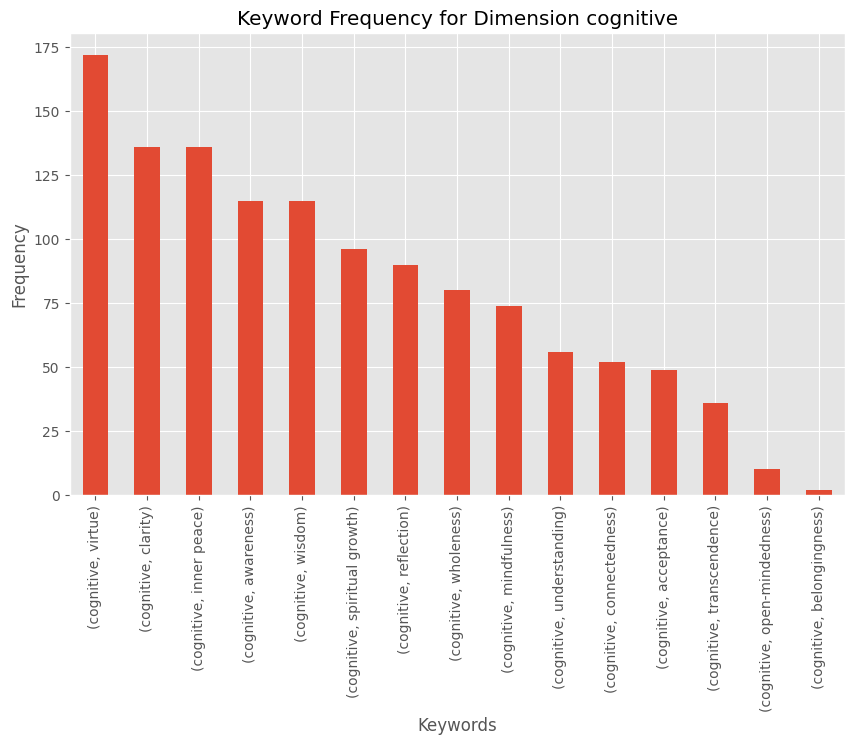

In [ ]:
grouped = df.groupby('Dimension')['keyword'].value_counts()
# Plot each group separately
for dimension, data in grouped.groupby(level=0):
    plt.figure(figsize=(10, 6))
    data.plot(kind='bar', title=f'Keyword Frequency for Dimension {dimension}')
    plt.xlabel('Keywords')
    plt.ylabel('Frequency')
    plt.show()


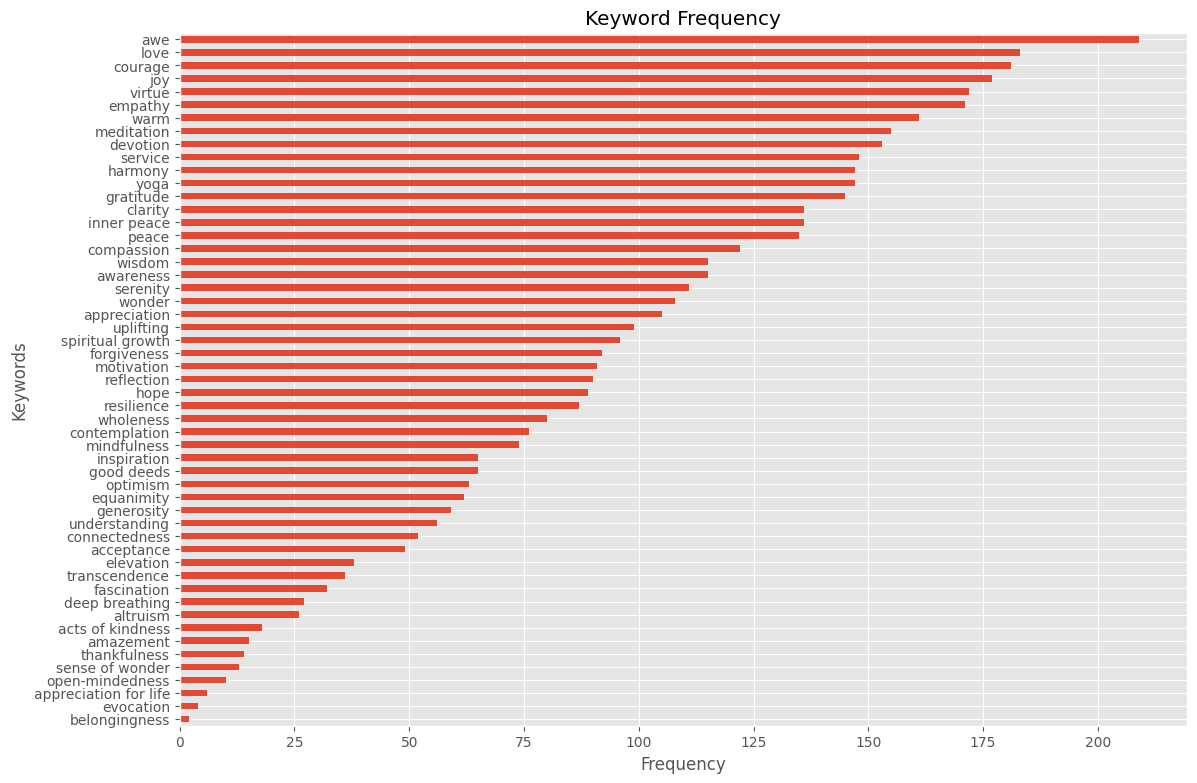

In [ ]:
# Count the frequency of each keyword
keyword_counts = df['keyword'].value_counts()
keyword_counts_sorted = keyword_counts.sort_values(ascending=True)

# Create a bar plot with keywords on the x-axis
plt.figure(figsize=(13, 9))
keyword_counts_sorted.plot(kind='barh')
plt.title('Keyword Frequency')
plt.xlabel('Frequency')
plt.ylabel('Keywords')
plt.show()

# Grouped bar plots
grouped = df.groupby('Dimension')['keyword'].value_counts().unstack(fill_value=0)


In [ ]:
# keyword average per dimension
keyword_counts = df['keyword'].value_counts()

# Calculate the average keyword count per dimension
average_keyword_counts = df.groupby('Dimension')['keyword'].value_counts().groupby('Dimension').mean()

# Print or display the result
print(round(average_keyword_counts))

Dimension
affective     98.0
behavioral    84.0
cognitive     81.0
Name: keyword, dtype: float64


In [ ]:
# Counting posts with 0 comments
zero_comments = (df['comments'] == 0).sum()

# Counting posts with more than 0 comments
more_than_zero_comments = (df['comments'] > 0).sum()

print(f"Number of posts with 0 comments: {zero_comments}")
print(f"Number of posts with more than 0 comments: {more_than_zero_comments}")
# Calculate the sum of comments for posts with more than 0 comments
total_comments_for_more_than_zero = df[df['comments'] > 0]['comments'].sum()

# Calculate the average number of comments for posts with more than 0 comments
average_nr_of_comm = total_comments_for_more_than_zero / more_than_zero_comments
print(f"Avg number of comments for posts with more than 0 comments: {average_nr_of_comm}")

Number of posts with 0 comments: 895
Number of posts with more than 0 comments: 3923
Avg number of comments for posts with more than 0 comments: 16.331124139689013


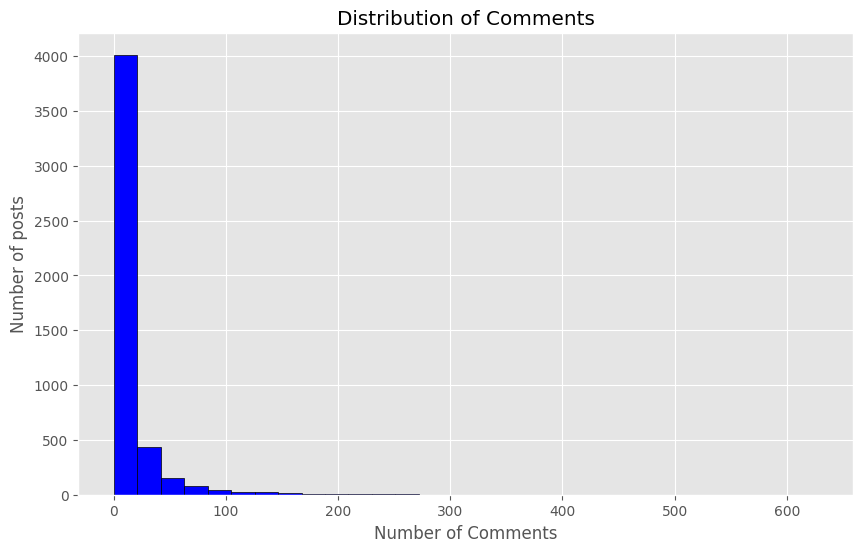

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['comments'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Comments')
plt.xlabel('Number of Comments')
plt.ylabel('Number of posts')
plt.grid(True)
plt.show()


# Sentiment Analysis with VADER

In [ ]:
# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['text']
    # Check for NaN values
    if pd.notna(text):
        myid = row['id']
        res[myid] = sia.polarity_scores(text)
    else:
      print(f"found NaN value {row['id']}")

print(res)

  0%|          | 0/4818 [00:00<?, ?it/s]

{1: {'neg': 0.074, 'neu': 0.72, 'pos': 0.206, 'compound': 0.9984}, 2: {'neg': 0.186, 'neu': 0.675, 'pos': 0.139, 'compound': -0.3393}, 3: {'neg': 0.019, 'neu': 0.774, 'pos': 0.207, 'compound': 0.9581}, 4: {'neg': 0.094, 'neu': 0.714, 'pos': 0.192, 'compound': 0.8993}, 5: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, 6: {'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'compound': 0.7929}, 7: {'neg': 0.0, 'neu': 0.885, 'pos': 0.115, 'compound': 0.8385}, 8: {'neg': 0.042, 'neu': 0.576, 'pos': 0.382, 'compound': 0.9042}, 9: {'neg': 0.0, 'neu': 0.605, 'pos': 0.395, 'compound': 0.9806}, 10: {'neg': 0.03, 'neu': 0.82, 'pos': 0.15, 'compound': 0.8316}, 11: {'neg': 0.17, 'neu': 0.767, 'pos': 0.063, 'compound': -0.8591}, 12: {'neg': 0.044, 'neu': 0.876, 'pos': 0.08, 'compound': 0.6794}, 13: {'neg': 0.0, 'neu': 0.76, 'pos': 0.24, 'compound': 0.9628}, 14: {'neg': 0.128, 'neu': 0.59, 'pos': 0.282, 'compound': 0.9954}, 15: {'neg': 0.054, 'neu': 0.746, 'pos': 0.2, 'compound': 0.9783}, 16: {'neg': 0.

In [ ]:
vader_result= pd.DataFrame(res).T

In [ ]:
vader_result =vader_result.reset_index().rename(columns = {'index' : 'id'})
vader_result = vader_result.merge(df, how = 'left')

In [ ]:
vader_result

,id,neg,neu,pos,compound,date_utc,timestamp,title,text,subreddit,comments,url,Dimension,keyword
0,1,0.074,0.720,0.206,0.9984,2014-01-02,1391261706,"vacuous imagery, cheap clichÃÂÃÂ©s, and fau...",Most of us like to think of ourselves as sensi...,spirituality,0,https://www.reddit.com/r/spirituality/comments...,cognitive,wisdom
1,2,0.186,0.675,0.139,-0.3393,2023-06-15,1686797377,Is it possible to reverse illness with manifes...,So I'm desperate. Doctors can help me they pre...,spirituality,57,https://www.reddit.com/r/spirituality/comments...,cognitive,wisdom
2,3,0.019,0.774,0.207,0.9581,2023-07-06,1686109290,Does our hair really have a spiritual connecti...,I always heard throughout the net that our hai...,spirituality,36,https://www.reddit.com/r/spirituality/comments...,cognitive,wisdom
3,4,0.094,0.714,0.192,0.8993,2023-11-14,1699960847,Psychic or spiritual interest,Hello everyone. I am interested in psychic or ...,spirituality,5,https://www.reddit.com/r/spirituality/comments...,cognitive,wisdom
4,5,0.000,1.000,0.000,0.0000,2023-05-05,1683315350,How are Spirituality and Philosophy different?,I am usually fancinated by ideas invoked by pr...,spirituality,17,https://www.reddit.com/r/spirituality/comments...,cognitive,wisdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4813,4814,0.067,0.721,0.212,0.9991,2019-01-26,1548529507,Karma and Overall Life Satisfaction and happin...,I am going to define Karma from a practical po...,spirituality,21,https://www.reddit.com/r/spirituality/comments...,behavioral,good deeds
4814,4815,0.017,0.812,0.171,0.9926,2021-12-31,1640940036,Invite your Angel now.,I've been through amazing discoveries.First of...,spirituality,1,https://www.reddit.com/r/spirituality/comments...,behavioral,good deeds
4815,4816,0.011,0.840,0.149,0.9692,2014-09-18,1411054839,how can I sanctify my worldly day to day life?,i guess i have wondered about this question fo...,spirituality,6,https://www.reddit.com/r/spirituality/comments...,behavioral,good deeds
4816,4817,0.146,0.592,0.262,0.9918,2017-12-30,1514607774,Avoiding False Hope and Pride,"VAIN is the man who puts his trust in men, in ...",spirituality,0,https://www.reddit.com/r/spirituality/comments...,behavioral,good deeds


# Sentiment Analysis with the RoBERTa Pretrained Model
From HuggingFace

In [ ]:
# Switch to GPU
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
# Load RoBERTa model and tokenizer
model= f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForSequenceClassification.from_pretrained(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Define a function to calculate RoBERTa sentiment scores
def polarity_scores_roberta(example):
  encoded_text= tokenizer(example, return_tensors = "pt")
  output= model(**encoded_text)
  scores= output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {'roberta_neg' : scores[0],
               'roberta_neu' : scores[1],
               'roberta_pos' : scores[2]
               }
  return scores_dict

In [ ]:
combined_res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
      text = row['text']
      if pd.notna(text):
          myid = row['id']

          # Split long text into smaller chunks
          text_chunks = [text[i:i + 512] for i in range(0, len(text), 512)]

          vader_total = {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
          roberta_total = {'roberta_neg': 0, 'roberta_neu': 0, 'roberta_pos': 0}

          for chunk in text_chunks:
              vader_result = sia.polarity_scores(chunk)  # Use NLTK's SentimentIntensityAnalyzer
              roberta_result = polarity_scores_roberta(chunk)

              # Accumulate VADER scores
              vader_total['neg'] += vader_result['neg']
              vader_total['neu'] += vader_result['neu']
              vader_total['pos'] += vader_result['pos']
              vader_total['compound'] += vader_result['compound']

              # Accumulate RoBERTa scores
              roberta_total['roberta_neg'] += roberta_result['roberta_neg']
              roberta_total['roberta_neu'] += roberta_result['roberta_neu']
              roberta_total['roberta_pos'] += roberta_result['roberta_pos']


          # Calculate the mean of scores for each method and round to 5 decimal places
          num_chunks = len(text_chunks)
          vader_total['neg'] = round(vader_total['neg'] / num_chunks, 5)
          vader_total['neu'] = round(vader_total['neu'] / num_chunks, 5)
          vader_total['pos'] = round(vader_total['pos'] / num_chunks, 5)
          vader_total['compound'] = round(vader_total['compound'] / num_chunks, 5)

          roberta_total['roberta_neg'] = round(roberta_total['roberta_neg'] / num_chunks, 5)
          roberta_total['roberta_neu'] = round(roberta_total['roberta_neu'] / num_chunks, 5)
          roberta_total['roberta_pos'] = round(roberta_total['roberta_pos'] / num_chunks, 5)


          combined_res[myid] = {'id': myid, **vader_total, **roberta_total}

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4818/4818 [1:51:19<00:00,  1.39s/it]


In [ ]:
# Create a DataFrame from the combined_res dictionary
result_df_try = pd.DataFrame.from_dict(combined_res, orient='index')
result_df_try.reset_index(drop=True, inplace=True)

# Process the combined results as needed
print(result_df_try)

        id      neg      neu      pos  compound  roberta_neg  roberta_neu  \
0        1  0.04262  0.80538  0.15188   0.65126      0.22350      0.56412   
1        2  0.14150  0.71700  0.14150   0.08790      0.77076      0.18752   
2        3  0.01000  0.48800  0.50250   0.77340      0.02253      0.36357   
3        4  0.04800  0.85400  0.09800   0.44965      0.18381      0.72221   
4        5  0.00000  1.00000  0.00000   0.00000      0.06666      0.86706   
...    ...      ...      ...      ...       ...          ...          ...   
4813  4814  0.04850  0.78375  0.16775   0.53224      0.22415      0.58523   
4814  4815  0.02175  0.79575  0.18250   0.89092      0.00950      0.08812   
4815  4816  0.00900  0.85350  0.13700   0.83680      0.45107      0.49806   
4816  4817  0.12500  0.63767  0.23733   0.79513      0.20973      0.46244   
4817  4818  0.01900  0.72300  0.25800   0.95312      0.00355      0.22359   

      roberta_pos  
0         0.21238  
1         0.04172  
2         0.613

Saving the results into a file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Define the file path and name within the directory
file_path = '/content/drive/My Drive/SA/sentiment_analysis_roberta.csv'


# Extract 'Dimension' and 'keyword' columns
dimensions = df['Dimension']
keywords = df['keyword']
text = df['text']

# Add 'dimensions' and 'keywords' columns to 'result_df'
result_df_try = pd.concat([result_df_try, dimensions, keywords, text], axis=1)
print(result_df_try.columns)

# Save the DataFrame to a CSV file
result_df_try.to_csv(file_path, encoding='utf-8', index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['id', 'neg', 'neu', 'pos', 'compound', 'roberta_neg', 'roberta_neu',
       'roberta_pos', 'Dimension', 'keyword', 'text'],
      dtype='object')


# Comparison on one single example

Let's compare HuggingFace with Vader.

In [ ]:
single_example = """What a terrible world we live in! Even though it is nice sometimes, I wish people would be kinder!!!"""

In [ ]:
#Vader
sia.polarity_scores(single_example)

{'neg': 0.119, 'neu': 0.501, 'pos': 0.38, 'compound': 0.7762}

In [ ]:
#roBERTa
polarity_scores_roberta(single_example)

{'roberta_neg': 0.935925,
 'roberta_neu': 0.055057608,
 'roberta_pos': 0.009017361}